Aim: To reproduce the plot from this document: https://journals-aps-org.abc.cardiff.ac.uk/prl/pdf/10.1103/PhysRevLett.95.109902, as derived in this document: https://journals-aps-org.abc.cardiff.ac.uk/prl/pdf/10.1103/PhysRevLett.92.246401

First let us define some functions. We start with LDA energy density:

In [39]:
from scipy.constants import pi

# LDA taken from this page: https://www.theoretical-physics.net/dev/quantum/dft.html
# And verified against LibXC for densities of 0 to 1.
def lda_exchange_energy(density):
    return (-3/4)*((3*density)/pi)**(1/3)
    #return (-3/(4*pi))*((3*(pi**2)*density))**(1/3)

def lda_correlation_energy(density):
    from numpy import arctan, log # This is natural log
    
    y_0 = -0.10498
    A = 0.0621814
    b = 3.72744
    c = 12.9352
    electron_gas_parameter = (3/(4*pi*density))**(1/3)
    y = (electron_gas_parameter)**(1/2)
    Y_y = (y**2) + (b*y) + c
    Y_y0 = (y_0**2) + (b*y_0) + c
    Q = (4*c - (b**2))**(1/2)
    part_1 = log((y**2)/Y_y)
    part_2 = (2*b/Q)*arctan(Q/((2*y)+b))
    part_3_prefactor = (b*y_0)/Y_y0
    part_3_1 = log(((y-y_0)**2)/Y_y)
    part_3_2 = ((2*(b+2*y_0))/Q)*arctan(Q/((2*y)+b))
    part_3_total = -part_3_prefactor*(part_3_1+part_3_2)
    
    return (part_1+part_2+part_3_total)*(A/2)

Looks lovely, but I don't trust it unless we can validate, so lets do that.

In [58]:
def validate_lda():
    import numpy as np
    density = np.arange(0.0,1.1,0.1)
    exchange = lda_exchange_energy(density)
    correlation = lda_correlation_energy(density)
    
    # Here are equivalent results calculated with LibXC 
    exchange_libxc = np.array([ 0., -0.34280861, -0.43191179, -0.49441557, -0.54417475, -0.58619448, -0.62292459, -0.65576928, -0.68561722, -0.71307065, -0.73855877])
    correlation_libxc = np.array([ 0., -0.05339729, -0.05864492, -0.06181076, -0.0640977,  -0.06589402, -0.06737584, -0.06863838, -0.06973906, -0.07071524, -0.07159261])
    
    import matplotlib.pyplot as plt
    plt.plot(density, exchange_libxc, "green")
    plt.plot(density, correlation_libxc, "green")
    plt.plot(density, exchange, "blue")
    plt.plot(density, correlation, "blue")
    plt.xlabel('Density (e/a_0^3)')
    plt.ylabel('Energy (Ha)')
    plt.show()

<ipython-input-39-1684cba6169b>:16: RuntimeWarning: divide by zero encountered in true_divide
  electron_gas_parameter = (3/(4*pi*density))**(1/3)
<ipython-input-39-1684cba6169b>:21: RuntimeWarning: invalid value encountered in true_divide
  part_1 = log((y**2)/Y_y)
<ipython-input-39-1684cba6169b>:24: RuntimeWarning: invalid value encountered in true_divide
  part_3_1 = log(((y-y_0)**2)/Y_y)


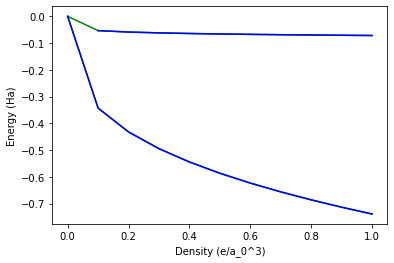

In [60]:
validate_lda()

The only notable difference is behaviour at low density, where we get an NaN response. So to deal with that we'll just wrap the correlation with something that checks the density threshold:

In [94]:
def lda_exchange_correlation_energy(density):
    import numpy as np
    exchange = correlation = 0.0
    # Mask values if they are effectively zero
    if type(density) == np.ndarray:
        density_masked = np.ma.masked_where(density <= 1e-20, density)
    else:
        density_masked = density
    exchange = lda_exchange_energy(density_masked)
    correlation = lda_correlation_energy(density_masked)
        
    return exchange+correlation

import numpy as np
density = np.arange(0.0,1.1,0.1)
print(lda_exchange_correlation_energy(density))

[-- -0.3962059014865123 -0.49055670695522424 -0.5562263305315182
 -0.608272452558864 -0.6520885013143208 -0.6903004326262159
 -0.724407665582844 -0.755356284229314 -0.7837858872986903
 -0.810151378688813]


Now to calculate q_0, and everything else should be trivial. 

**This needs more work as q_0 is inconsistent**. Working through the maths, the differences between the top and bottom two definitions of q_0 are in the LHS of eq. 7, 10.1103/PhysRevB.76.125112, where _n_ is given instead of _(pi/3n)^(1/3)_ in the other two papers?

In [103]:
# Definitions here taken from: 10.1103/PhysRevB.76.125112
def fermi_wave_vector(density):
    return 3*(pi**2)*density

def reduced_gradient(density, gradient_of_density):
    numerator = gradient_of_density
    denominator = 2*fermi_wave_vector(density)*density
    return (numerator/denominator)

# Equation 7 of the aforementioned paper
def q_0(density, gradient_of_density):
    Z = -0.8491
    # Equation 7 of the aforementioned paper (10.1103/PhysRevB.76.125112)
    part_1 = (-4.0/3.0)*pi*lda_exchange_correlation_energy(density)*density
    part_2 = (Z/9.0)*(reduced_gradient(density,gradient_of_density)**2)*fermi_wave_vector(density)
    #return part_1 - part_2
    
    #Equation 11-12 of 10.1103/PhysRevLett.92.246401, which is where
    #the previous equation is taken from. However, I cannot get these to match?
    numerator = lda_exchange_correlation_energy(density)-lda_exchange_energy(density)*(Z/9)*reduced_gradient(density, gradient_of_density)**2
    denominator = lda_exchange_energy(density)
    #return (numerator/denominator)*fermi_wave_vector(density)

    # Equation 51, https://arxiv.org/pdf/1412.6827.pdf, which matches Eq 11-12 above.
    enhancement_factor = (1-(Z/9)*reduced_gradient(density, gradient_of_density))
    numerator = (lda_exchange_energy(density)*enhancement_factor)+lda_correlation_energy(density)
    denominator = lda_exchange_energy(density)
    return (numerator/denominator)*fermi_wave_vector(density)

density = np.arange(0.0,1.1,0.1)
print(q_0(density,0.0))

[        nan  3.42208046  6.72581872  9.99313274 13.23856012 16.46856738
 19.6867906  22.8955461  26.09643086 29.29060812 32.47896028]


<ipython-input-103-cdec3dd9572c>:8: RuntimeWarning: invalid value encountered in true_divide
  return (numerator/denominator)
<ipython-input-39-1684cba6169b>:16: RuntimeWarning: divide by zero encountered in true_divide
  electron_gas_parameter = (3/(4*pi*density))**(1/3)
<ipython-input-39-1684cba6169b>:21: RuntimeWarning: invalid value encountered in true_divide
  part_1 = log((y**2)/Y_y)
<ipython-input-39-1684cba6169b>:24: RuntimeWarning: invalid value encountered in true_divide
  part_3_1 = log(((y-y_0)**2)/Y_y)


Appendix: Calculating LDA benchmark with LibXC.

(N.B. This won't work without LibXC installed)

In [53]:
# Interaction with libxc taken from this page: https://www.tddft.org/programs/libxc/installation/#python-library
from pylibxc import LibXCFunctional
from numpy import arange

inp={}
rho=arange(0.0,1.1,0.1)
print(rho[1])
inp["rho"] = rho
for func_name in ["LDA_X", "LDA_C_VWN"]:
    func = LibXCFunctional(func_name, "unpolarized")
    results = func.compute(inp)
    for key, value in results.items():
        if key=="zk":
            for i in range(len(rho)):
                print(rho[i], value[0][i])

ModuleNotFoundError: No module named 'pylibxc'